-low sparsity on MW, exclude mean FD outliers

# Get path of data

In [1]:
region_labels_fn = 'data/data_cross_corr_Bzdok_DMN16_preprocessed_ROIS.npy'
beh_keysfn = 'data/data_MWQ_keys.npy'
behavefn = 'data/data_MWQ_session_preprocessed.npy'
rscorrfn = 'data/data_cross_corr_Bzdok_DMN16_preprocessed.npy'

In [2]:
from os.path import expanduser
import numpy as np
%matplotlib inline
from funlib_scca import *

# Load data

In [3]:
behavioral_data = np.load(expanduser(behavefn))
rest_data = np.load(expanduser(rscorrfn))
subject_subset = behavioral_data[:, 0].astype('i4') - 1
penFC = 0.3
penMW_5 = 0.5

# Analysis 1: All instances

In [4]:
X = rest_data[subject_subset,:]
Y = behavioral_data[:,40:]

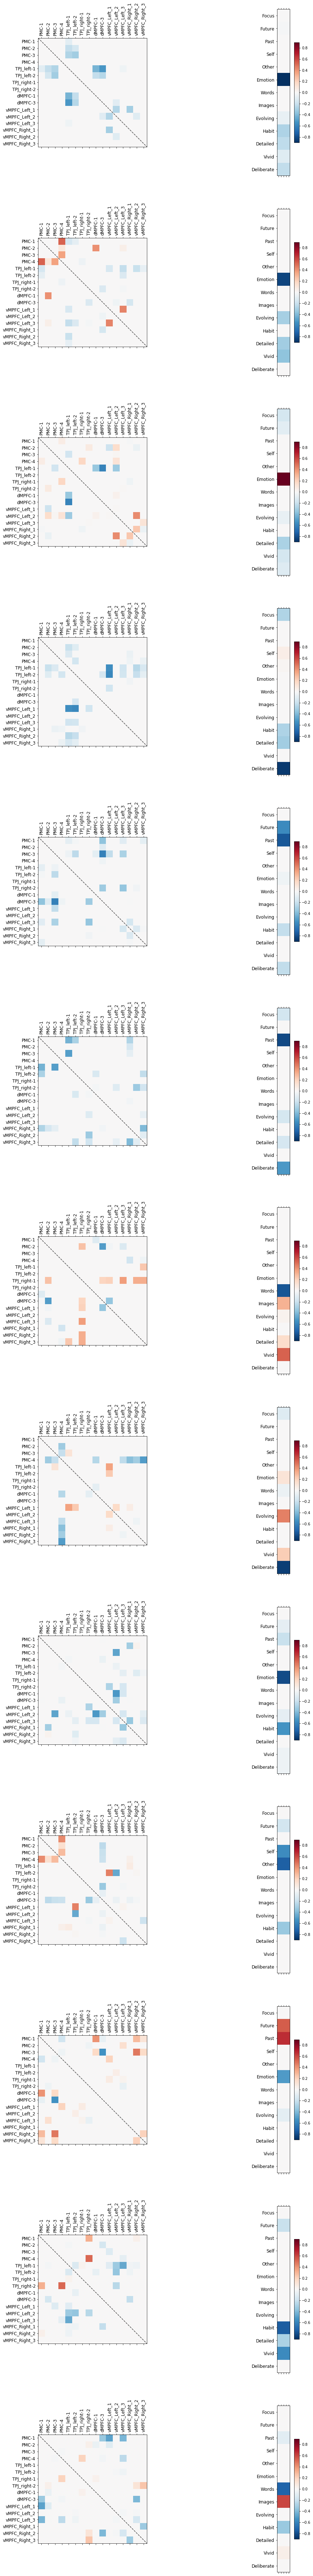

In [5]:
u, v = SCCA_r(X, Y, 13, penFC, penMW_5)
SCCA_Output_Sheet('Results/DMN_16_REVISION/DMN16_allInstances_penBrain%1.1fpenMW%1.1f' %(penFC, penMW_5), region_labels_fn, beh_keysfn, u, v)
ALL_CC_35 = csv_CanonicalScores(X, Y, u, v, subject_subset + 1, 'Results/DMN_16_REVISION/DMN16_allInstances_penBrain%1.1fpenMW%1.1f.csv' %(penFC, penMW_5))
# np.save('Results/DMN_16_REVISION/SCCAloading_all',(u, v))

# Analysis 2: Leave one random session out

## Create a leave one random session out sample

In [6]:
# Restart the random seed
np.random.seed(9999)
np.random.set_state(np.random.get_state())

def LOSO_resample():
    session_data = behavioral_data[:,1:40]
    #generate participant - ignored session random list
    drop_sessions = np.array([np.random.randint(1,4) for p in range(session_data.shape[0])])

    resample = np.zeros((session_data.shape[0], 13))
    for i, drop in enumerate(drop_sessions):
        cur_subj = session_data[i,:].reshape((3, 13))
        # drop session
        cur_data = np.delete(cur_subj, drop - 1, 0)
        cur_data = np.mean(cur_data, axis=0)
        resample[i,:] = cur_data

    data_imp = imputedata(resample, 'mean', missing=True) #impute outlier

    S = data_imp.sum(axis=0) / data_imp.shape[0]
    data_imp -= S[np.newaxis, :]
    var = (data_imp ** 2).sum(axis=0)
    var[var == 0] = 1
    data_imp /= var
    return data_imp

Y_LOSO = LOSO_resample()

## Do analysis

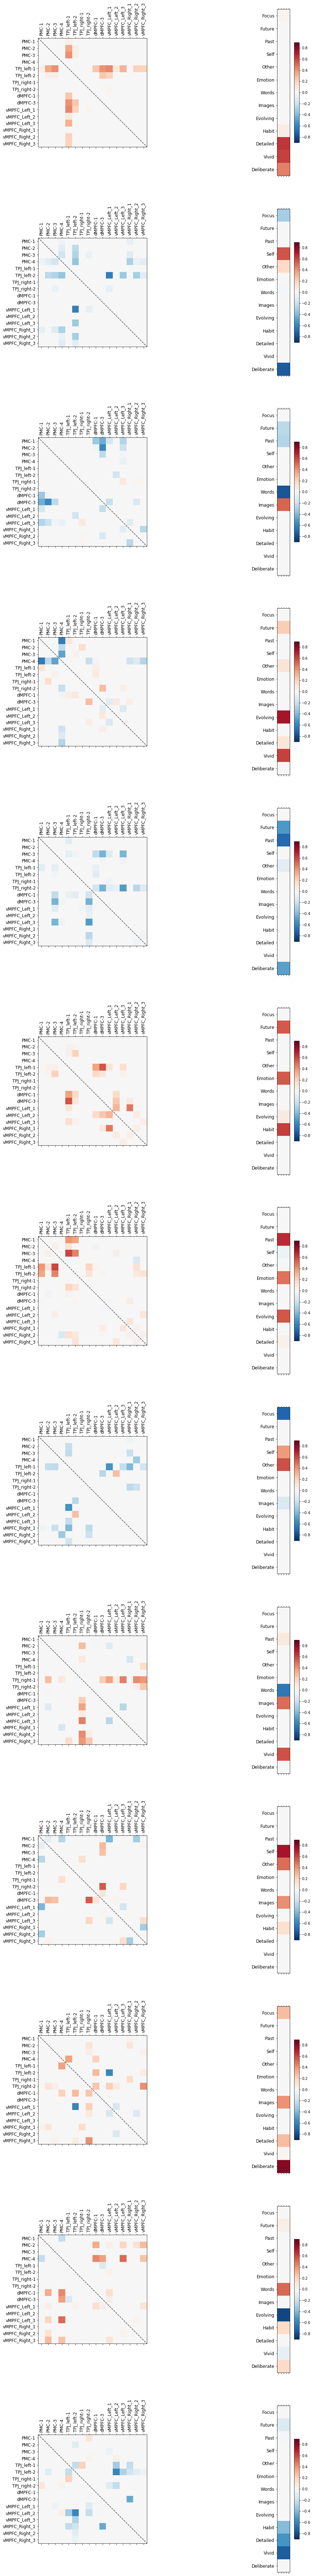

In [9]:
u, v = SCCA_r(X, Y_LOSO, 13, penFC, penMW_5)
np.save('Results/DMN_16_REVISION/SCCAloading_LOSO',(u, v))
SCCA_Output_Sheet('Results/DMN_16_REVISION/DMN16_LOSO_penBrain%1.1fpenMW%1.1f' %(penFC, penMW_5), region_labels_fn, beh_keysfn, u, v)
LOSO_CC_35 = csv_CanonicalScores(X, Y, u, v, subject_subset + 1, 'Results/DMN_16_REVISION/DMN16_LOSO_penBrain%1.1fpenMW%1.1f.csv' %(penFC, penMW_5))

# Analysis 3: Bootstrapping and SCCA on bootstrap sample

## Bootsrtapping and creat bootstrap sample

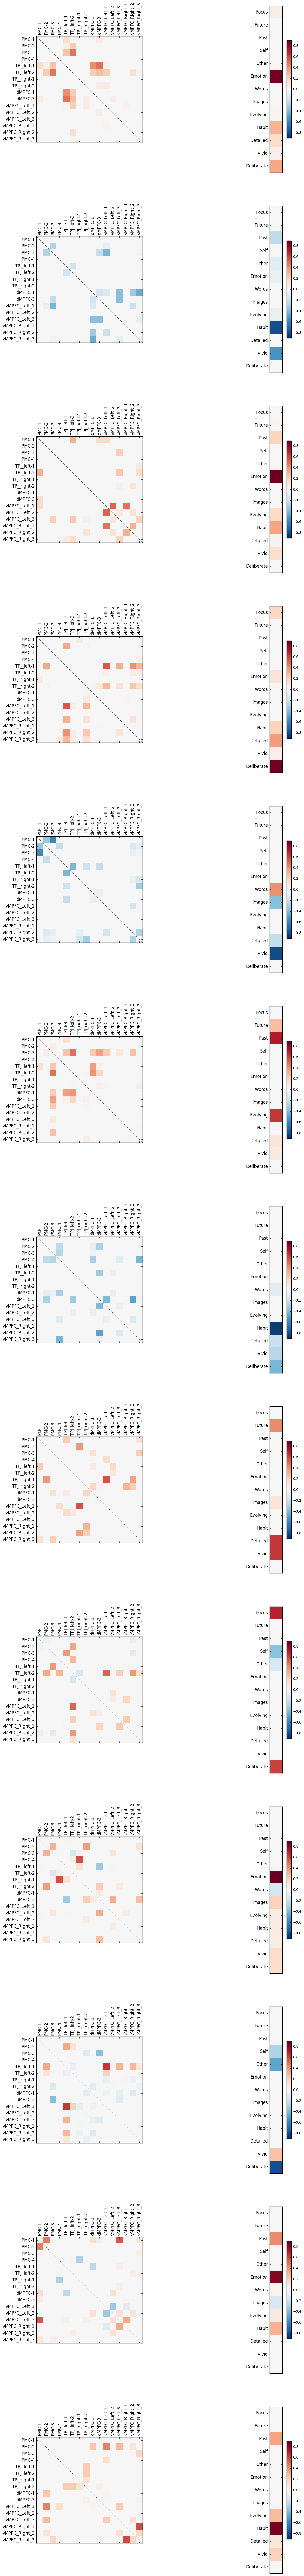

In [10]:
# randomly initialize the RNG from some platform-dependent source of entropy
np.random.seed(47)
np.random.set_state(np.random.get_state())

I = np.random.randint(X.shape[0],size=X.shape[0])
cur_X = X[I,:]
cur_Y = Y[I,:]
u, v = SCCA_r(cur_X, cur_Y, 13, penFC, penMW_5)
np.save('Results/DMN_16_REVISION/SCCAloading_BOOTS',(u, v))

SCCA_Output_Sheet('Results/DMN_16_REVISION/DMN16_BootstrapSample_penBrain%1.1fpenMW%1.1f' %(penFC, penMW_5), region_labels_fn, beh_keysfn, u, v)
BOOTS_CC_35 = csv_CanonicalScores(X, Y, u, v, subject_subset + 1, 'Results/DMN_16_REVISION/DMN16_BootstrapSample_penBrain%1.1fpenMW%1.1f.csv' %(penFC, penMW_5))

# Revison 2: Removing data with extreme MeanFD

In [101]:
import pandas as pd
from funlib_scca import *
import numpy as np
df = pd.read_csv('./data/CS_MeanFD.csv', header=0, index_col=0)
Mean_FD_j = df.values[:,2]
# exclude_FC = np.array(range(165))[is_outliers(Mean_FD_j)]
exclude_FC = np.array(range(165))[Mean_FD_j>9]
exclude_FC_idx = []
# find the index of exclude_FC in subject_subset
subject_subset = behavioral_data[:, 0].astype('i4') - 1
for i, sub in enumerate(subject_subset):
    if sub in exclude_FC:
        exclude_FC_idx.append(i)
    else:
        pass

In [102]:
behavioral_data = np.delete(behavioral_data, exclude_FC_idx, 0)
subject_subset = behavioral_data[:, 0].astype('i4') - 1
X = rest_data[subject_subset,:]
Y = behavioral_data[:,40:]
print X.shape
print Y.shape

(134L, 120L)
(134L, 13L)


# All instance

array([[  1.00000000e+00,  -2.03124153e+00,   2.31139464e-01, ...,
          5.07381823e-02,  -2.72659259e-02,   5.93469122e-02],
       [  2.00000000e+00,  -1.68964888e+00,   1.16403281e-01, ...,
          5.44710367e-02,  -7.72861879e-02,   1.54490988e-02],
       [  3.00000000e+00,  -1.57663968e+00,   5.63809209e-01, ...,
          4.24085942e-02,   2.72866353e-02,  -5.83620946e-02],
       ..., 
       [  1.62000000e+02,  -1.33429493e+00,   3.49555314e-01, ...,
          5.65591899e-02,  -2.94677042e-02,  -5.13164559e-03],
       [  1.63000000e+02,  -1.94161317e+00,  -4.53016435e-01, ...,
          2.89943562e-02,  -6.31958904e-02,  -2.65367563e-02],
       [  1.64000000e+02,  -1.74679933e+00,   9.23611322e-01, ...,
          3.25101910e-02,   4.90410103e-02,   9.27461869e-02]])

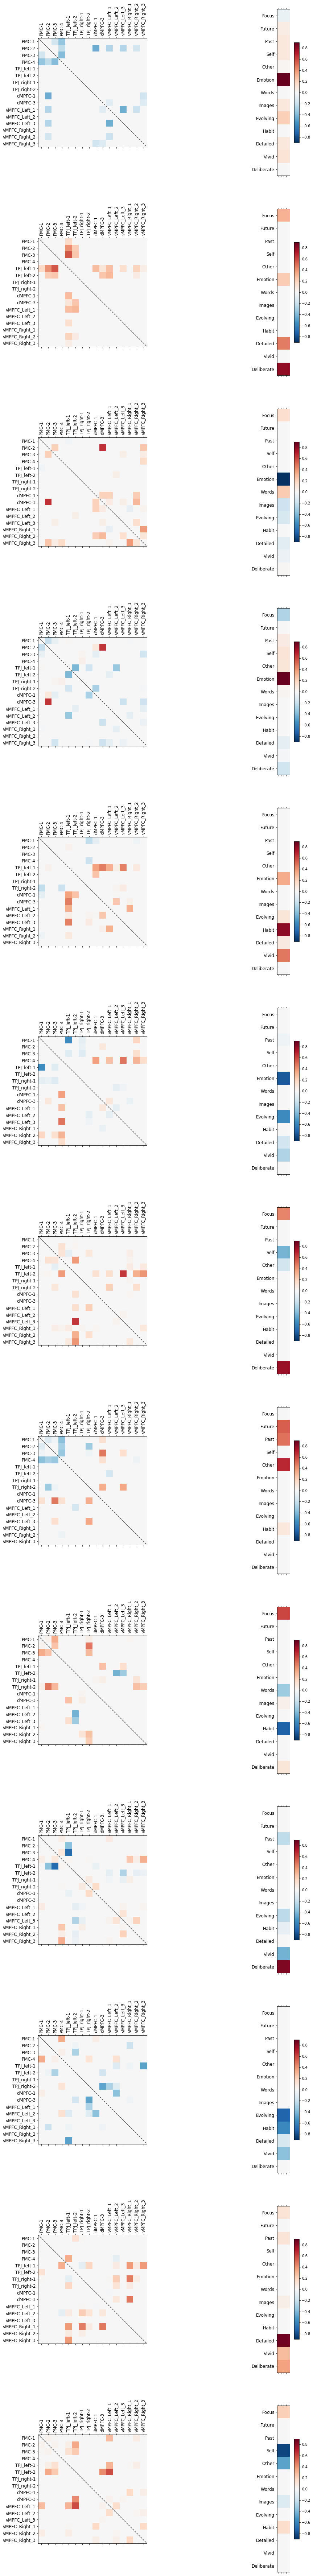

In [103]:
u, v = SCCA_r(X, Y, 13, penFC, penMW_5)
np.save('Results/RemoveHighFD/SCCAloading_All',(u, v))
SCCA_Output_Sheet('Results/RemoveHighFD/allInstances_penBrain%1.1fpenMW%1.1f' %(penFC, penMW_5), region_labels_fn, beh_keysfn, u, v)
csv_CanonicalScores(X, Y, u, v, subject_subset + 1, 'Results/RemoveHighFD/allInstances_penBrain%1.1fpenMW%1.1f.csv' %(penFC, penMW_5))

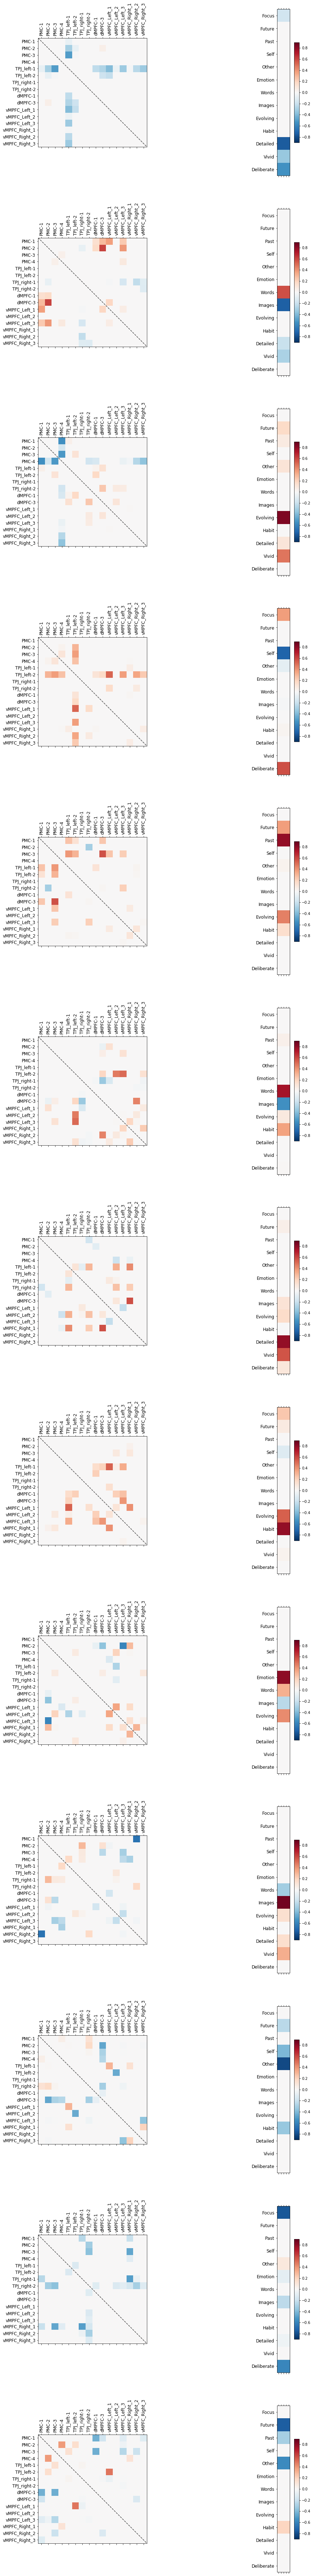

In [98]:
np.random.seed(9999)
np.random.set_state(np.random.get_state())
Y_LOSO = LOSO_resample()
u, v = SCCA_r(X, Y_LOSO, 13, penFC, penMW_5)
np.save('Results/RemoveHighFD/SCCAloading_LOSO',(u, v))
SCCA_Output_Sheet('Results/RemoveHighFD/LOSO_penBrain%1.1fpenMW%1.1f_new' %(penFC, penMW_5), region_labels_fn, beh_keysfn, u, v)
LOSO_CC_35 = csv_CanonicalScores(X, Y, u, v, subject_subset + 1, 'Results/RemoveHighFD/LOSO_penBrain%1.1fpenMW%1.1f_new.csv' %(penFC, penMW_5))

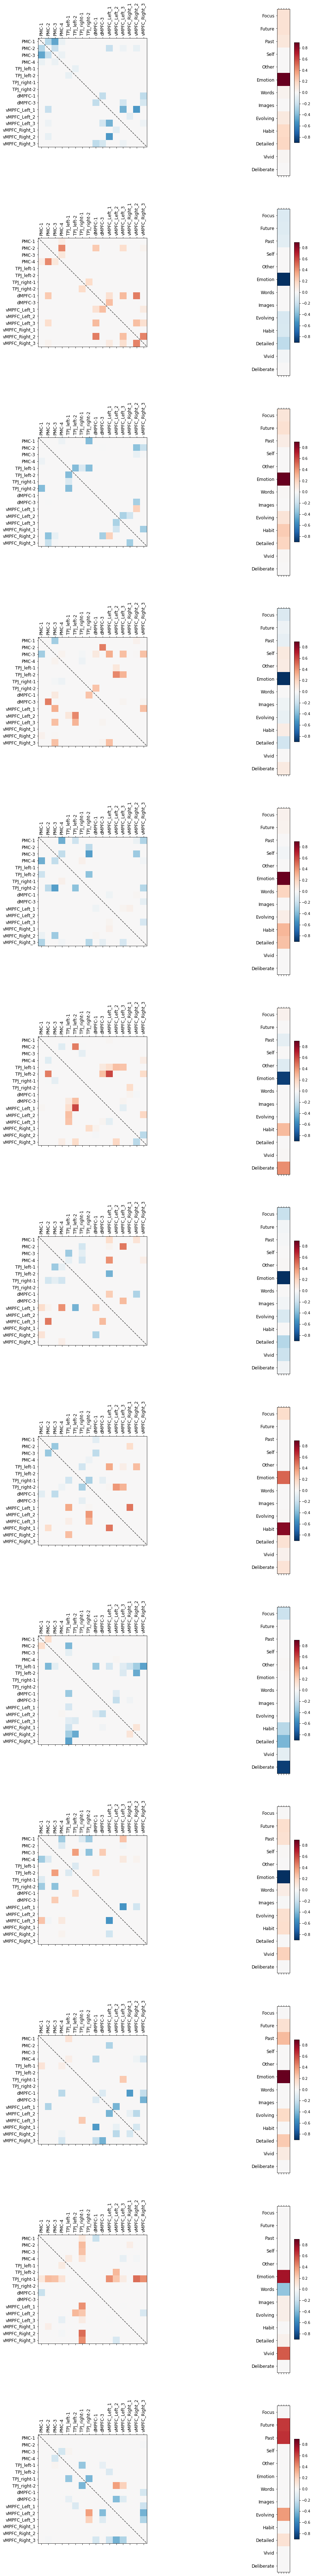

In [99]:
np.random.seed(42)
np.random.set_state(np.random.get_state())

I = np.random.randint(X.shape[0],size=X.shape[0])
cur_X = X[I,:]
cur_Y = Y[I,:]
u, v = SCCA_r(cur_X, cur_Y, 13, penFC, penMW_5)
np.save('Results/RemoveHighFD/SCCAloading_BOOTS',(u, v))

SCCA_Output_Sheet('Results/RemoveHighFD/BOOTS_penBrain%1.1fpenMW%1.1f' %(penFC, penMW_5), region_labels_fn, beh_keysfn, u, v)
BOOTS_CC_35 = csv_CanonicalScores(X, Y, u, v, subject_subset + 1, 'Results/RemoveHighFD/BOOTS_penBrain%1.1fpenMW%1.1f.csv' %(penFC, penMW_5))